<p>
    libraries.py will instal all the libraries specified inside this module. Specifically, it will update pip and install all the modules specified inside libraries list.
</p>

In [1]:
!python libraries.py

2024-09-07 16:06:46,157 - INFO - Upgrading pip...
2024-09-07 16:06:46,157 - INFO - Running pip command: install --upgrade pip
2024-09-07 16:06:54,480 - INFO - Command 'install --upgrade pip' executed successfully.
2024-09-07 16:06:54,480 - INFO - pip upgraded successfully.
2024-09-07 16:06:54,481 - INFO - Installing library numpy...
2024-09-07 16:06:54,481 - INFO - Running pip command: install numpy
2024-09-07 16:06:58,382 - INFO - Command 'install numpy' executed successfully.
2024-09-07 16:06:58,382 - INFO - numpy installed successfully.
2024-09-07 16:06:58,382 - INFO - Installing library pandas...
2024-09-07 16:06:58,382 - INFO - Running pip command: install pandas
2024-09-07 16:07:02,738 - INFO - Command 'install pandas' executed successfully.
2024-09-07 16:07:02,738 - INFO - pandas installed successfully.
2024-09-07 16:07:02,739 - INFO - Installing library matplotlib...
2024-09-07 16:07:02,739 - INFO - Running pip command: install matplotlib
2024-09-07 16:07:06,213 - INFO - Comman

<p>
    It checks if GPU is available. Then it will print which devices you can use.
</p>

In [2]:
import tensorflow as tf
print(f'tf.config.list_physical_devices("GPU") = {tf.config.list_physical_devices("GPU")}')

tf.config.list_physical_devices("GPU") = []


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2633082849241624826
xla_global_id: -1
]


In [4]:
import os
import numpy as np
import pandas as pd
import utils
import custom

<p>
    This list will be used later to evaluate trained models metrics.
</p>

In [5]:
metrics = []

<h1>
    Adaptive H-Infinity Filter
</h1>
<p>
    <strong>AHIF</strong> is a simplified Adaptive H-Infinity Filter based on Kalman gain. It is used later to filter out noisy SOC estimates predicted by trained models.
</p>

<ul>
    <li>The <strong>process variance</strong> is initially small because it represents model uncertainty. At the beginning, it is assumed that the model is very accurate and, therefore, the variance is set to a low value. Obviously, it will be adapted during processing. This parameter will be adapted every 10 measurements because 10 residuals are quite enough statistical information to predict model variance correctly. Specifically, residuals are very important because if they are highly variable, then the model is not accurate, while if they are low constant values, the model variance can be reduced (the model is accurate).</li>
    <li>
        The <strong>measurement variance</strong> is set to a high value because it is assumed that measurements from sensors are very noisy.
    </li>
    <li>
        The <strong>initial error covariance</strong> is initially set to 1 (high uncertainty) because, at first, it is assumed a high measurement uncertainty.
    </li>
    <li>The <strong>Kalman gain</strong> represents how much we can trust the measurement versus prediction. If the measurement is very noisy (high measurement variance/uncertainty), then the Kalman gain will be low because the measurement cannot be trusted, and we will trust the prediction. \[ KG = \frac{PEC}{PEC + MV} \] where: 
        <ul>
            <li>KG is the Kalman gain</li>
            <li>PEC is the predicted error covariance</li>
            <li>MV is the measurement variance</li>
        </ul>
    </li>
    <li>
        The <strong>error covariance</strong> should be updated because of newly acquired information. So, the more data collected, the more the prediction confidence will be high (Bayesian Filter principles).
    </li>
</ul>

In [6]:
ahif = custom.AHIF()

INFO:root:Initialized AHIF with process_variance=1e-05, measurement_variance=0.1, initial_estimate=0, initial_error_covariance=1


<h1>
    Dataset
</h1>
<p>
    You can find the full dataset at the following link: <a href="https://doi.org/10.17632/cp3473x7xv.3">LG 18650HG2 Li-ion Battery Data</a>
    <blockquote>The included tests were performed at McMaster University in Hamilton, Ontario, Canada by Dr. Phillip Kollmeyer </blockquote>
</p>
Specifically, a class is designed to obtain automatically, through get_dataset() method, normalized arrays. In particular, these arrays represents training, validation and testing features and target. The dataset directory is specified as data path in the costructor where it is assumed that it contains 'train', 'val' and 'test' subdirectories.

In [7]:
import dataset

data = dataset.LGHG2(data_dir='./data')
X_train, X_val, X_test, y_train, y_val, y_test = data.get_dataset()

INFO:root:./data = ['test', 'train', 'val']
INFO:root:./data\train = ['TRAIN_LGHG2@n10degC_to_25degC_Norm_5Inputs.csv']
INFO:root:./data\val = ['01_TEST_LGHG2@n10degC_Norm_(05_Inputs).csv', '02_TEST_LGHG2@0degC_Norm_(05_Inputs).csv', '03_TEST_LGHG2@10degC_Norm_(05_Inputs).csv']
INFO:root:./data\test = ['04_TEST_LGHG2@25degC_Norm_(05_Inputs).csv']
INFO:root:train_data_df loaded.
INFO:root:val_data_df loaded.
INFO:root:test_data_df loaded.
INFO:root:data_columns = Index(['V', 'I', 'Temp', 'V_avg', 'I_avg', 'SOC'], dtype='object')
INFO:root:features = ['V', 'I', 'Temp', 'V_avg', 'I_avg']
INFO:root:target = ['SOC']


In [8]:
'''
Call the get_dfs() method to retrieve the loaded DataFrames for training, validation, and testing.
The method returns the DataFrames containing the raw data for each dataset, which are then assigned to the variables train_data_df, val_data_df, and test_data_df, respectively.
'''
train_data_df, val_data_df, test_data_df = data.get_dfs()

In [10]:
train_data_df

,V,I,Temp,V_avg,I_avg,SOC
0,0.385148,0.75102,0.303101,0.385148,0.75102,0.206417
1,0.385152,0.75102,0.304591,0.385150,0.75102,0.206417
2,0.385156,0.75102,0.306081,0.385152,0.75102,0.206417
3,0.385160,0.75102,0.307572,0.385154,0.75102,0.206417
4,0.385164,0.75102,0.309062,0.385156,0.75102,0.206417
...,...,...,...,...,...,...
669951,0.478843,0.75102,0.008477,0.459558,0.75102,0.283243
669952,0.478843,0.75102,0.008477,0.459699,0.75102,0.283243
669953,0.478843,0.75102,0.008477,0.459839,0.75102,0.283243
669954,0.478961,0.75102,0.008477,0.459979,0.75102,0.283243


<p>
    Using isna().sum() method on the DataFrame we will count the number of missing values in each column.
</p>

In [7]:
train_data_df.isna().sum()

V        0
I        0
Temp     0
V_avg    0
I_avg    0
SOC      0
dtype: int64

<p>
    Using info() method on the DataFrame we will get a coincise summary of it, including the number of non-null entries, data types of each column, and memory usage.
</p>

In [8]:
train_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669956 entries, 0 to 669955
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V       669956 non-null  float64
 1   I       669956 non-null  float64
 2   Temp    669956 non-null  float64
 3   V_avg   669956 non-null  float64
 4   I_avg   669956 non-null  float64
 5   SOC     669956 non-null  float64
dtypes: float64(6)
memory usage: 30.7 MB


In [11]:
val_data_df

,V,I,Temp,V_avg,I_avg,SOC
0,0.967308,0.749218,0.005644,0.967308,0.749218,1.000000
1,0.957333,0.746992,0.005644,0.962321,0.748105,0.999990
2,0.953690,0.747098,0.005644,0.959444,0.747769,0.999983
3,0.952046,0.747098,0.005644,0.957594,0.747602,0.999973
4,0.951106,0.747098,0.005644,0.956297,0.747501,0.999963
...,...,...,...,...,...,...
126102,0.335128,0.751020,0.532568,0.329741,0.751020,0.194990
126103,0.335128,0.751020,0.532568,0.329778,0.751020,0.194990
126104,0.335128,0.751020,0.532568,0.329815,0.751020,0.194990
126105,0.335128,0.751020,0.532568,0.329851,0.751020,0.194990


In [10]:
val_data_df.isna().sum()

V        0
I        0
Temp     0
V_avg    0
I_avg    0
SOC      0
dtype: int64

In [11]:
val_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126107 entries, 0 to 126106
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V       126107 non-null  float64
 1   I       126107 non-null  float64
 2   Temp    126107 non-null  float64
 3   V_avg   126107 non-null  float64
 4   I_avg   126107 non-null  float64
 5   SOC     126107 non-null  float64
dtypes: float64(6)
memory usage: 5.8 MB


In [13]:
test_data_df

,V,I,Temp,V_avg,I_avg,SOC
0,0.966960,0.748900,0.920678,0.966960,0.748900,1.000000
1,0.966020,0.746992,0.920677,0.966490,0.747946,0.999990
2,0.965901,0.746992,0.917845,0.966294,0.747628,0.999983
3,0.965783,0.747098,0.917845,0.966166,0.747496,0.999973
4,0.965665,0.746992,0.917845,0.966066,0.747395,0.999963
...,...,...,...,...,...,...
47512,0.298614,0.751020,0.926344,0.292723,0.751020,0.136623
47513,0.298614,0.751020,0.926344,0.292761,0.751020,0.136623
47514,0.298614,0.751020,0.926344,0.292798,0.751020,0.136623
47515,0.298614,0.751020,0.929177,0.292834,0.751020,0.136623


In [13]:
test_data_df.isna().sum()

V        0
I        0
Temp     0
V_avg    0
I_avg    0
SOC      0
dtype: int64

In [14]:
test_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47517 entries, 0 to 47516
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V       47517 non-null  float64
 1   I       47517 non-null  float64
 2   Temp    47517 non-null  float64
 3   V_avg   47517 non-null  float64
 4   I_avg   47517 non-null  float64
 5   SOC     47517 non-null  float64
dtypes: float64(6)
memory usage: 2.2 MB


<h1>
    Data visualization
</h1>

<p>
    A pie chart is used to visualize the distribution of the dataset among training, validation, and test sets.
</p>

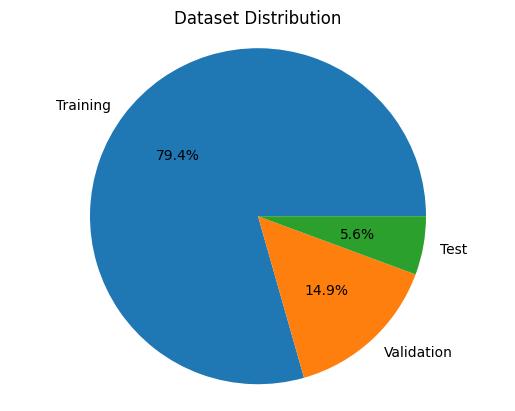

In [16]:
utils.pie_chart_plot(
    train_data_df=train_data_df, 
    val_data_df=val_data_df, 
    test_data_df=test_data_df
)

<p>
    Violin plots are used to visualize the distribution of features for training, validation, and test datasets.
</p>

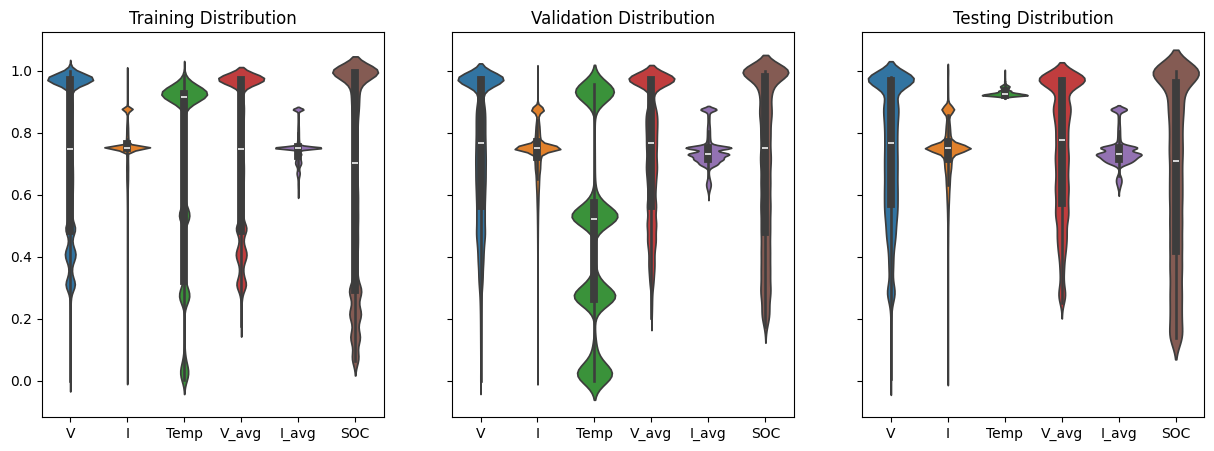

In [17]:
utils.violin_plot(
    train_data_df=train_data_df, 
    val_data_df=val_data_df, 
    test_data_df=test_data_df
)

<p>
    Histograms are used to visualize the distribution of each feature for training, validation, and test datasets.
</p>

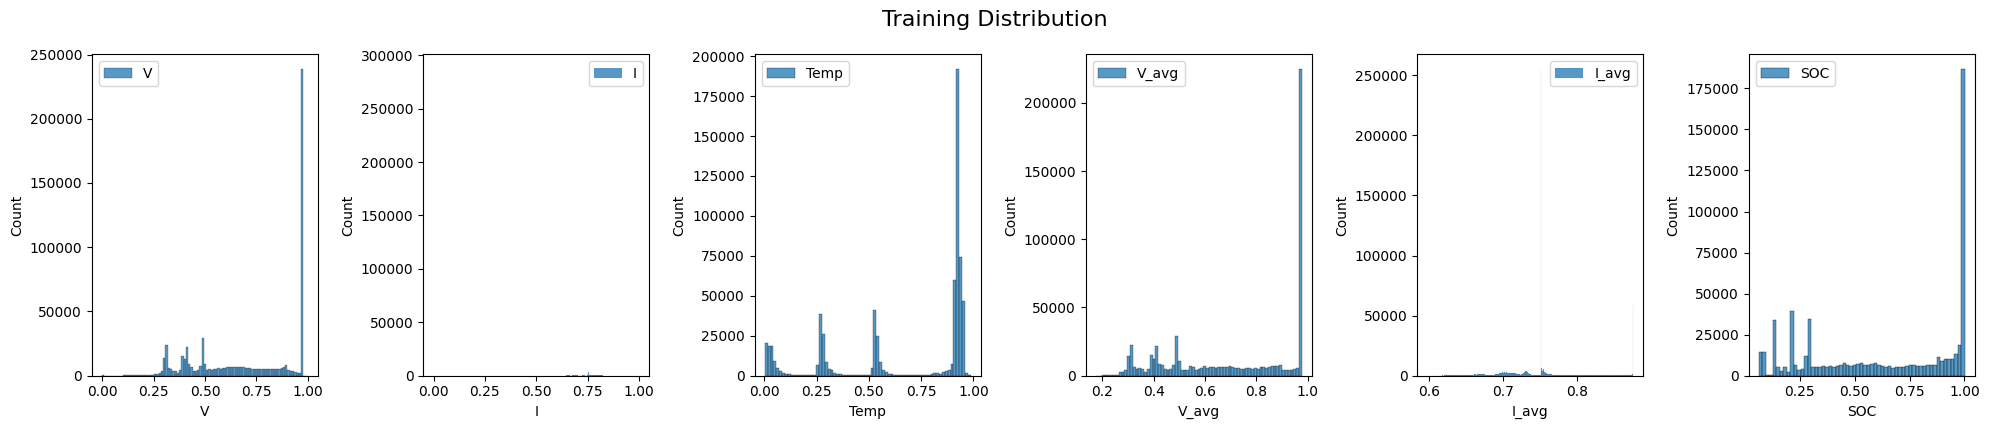

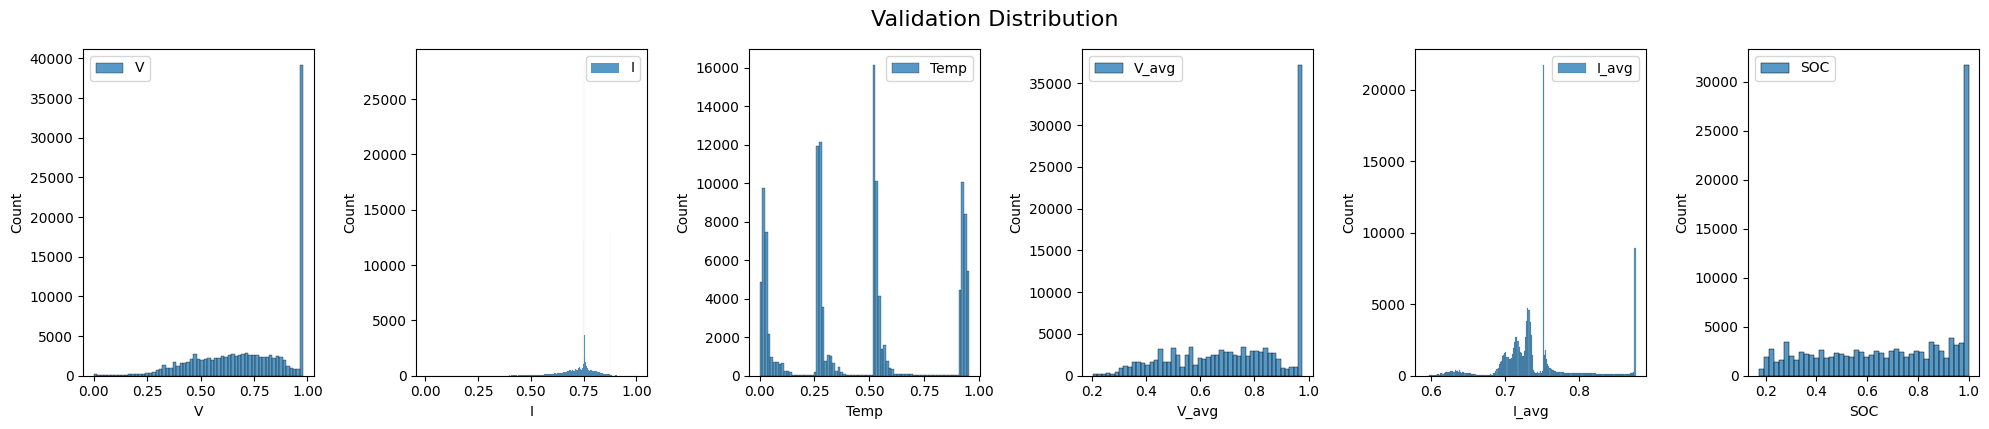

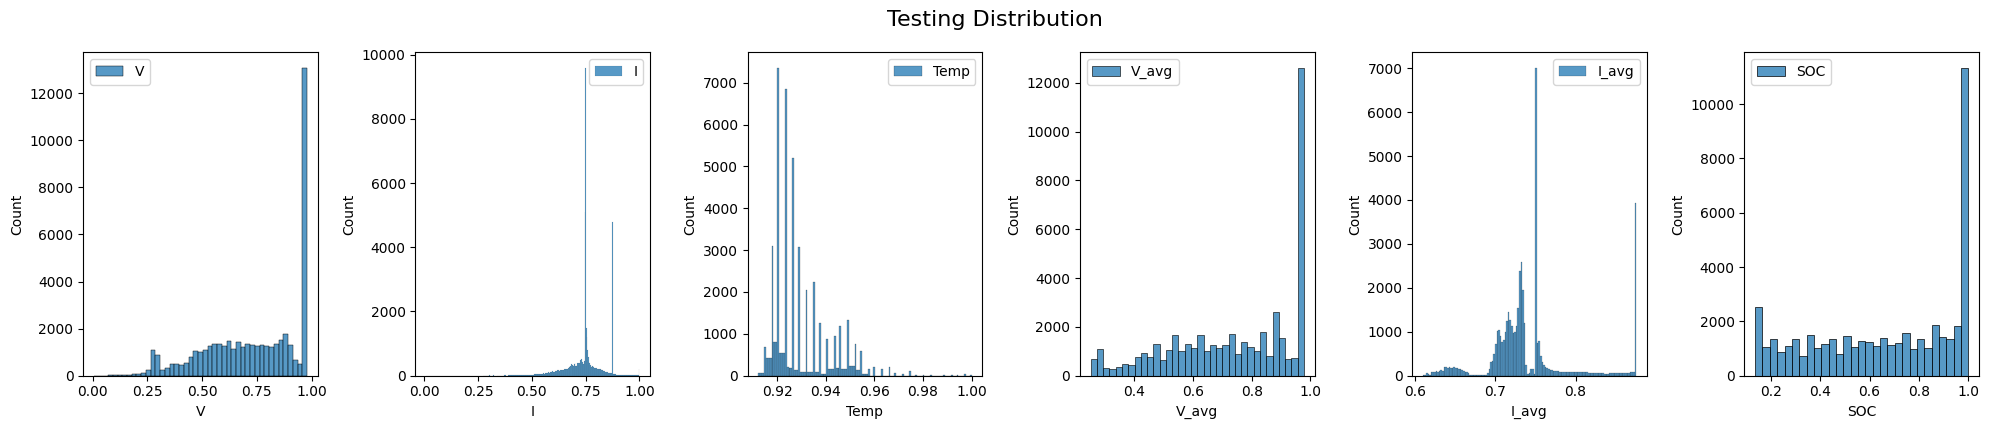

In [18]:
utils.hist_plot(
    train_data_df=train_data_df, 
    val_data_df=val_data_df, 
    test_data_df=test_data_df
)

<p>
    Line plots are used to visualize time series data for training, validation, and test datasets.
</p>

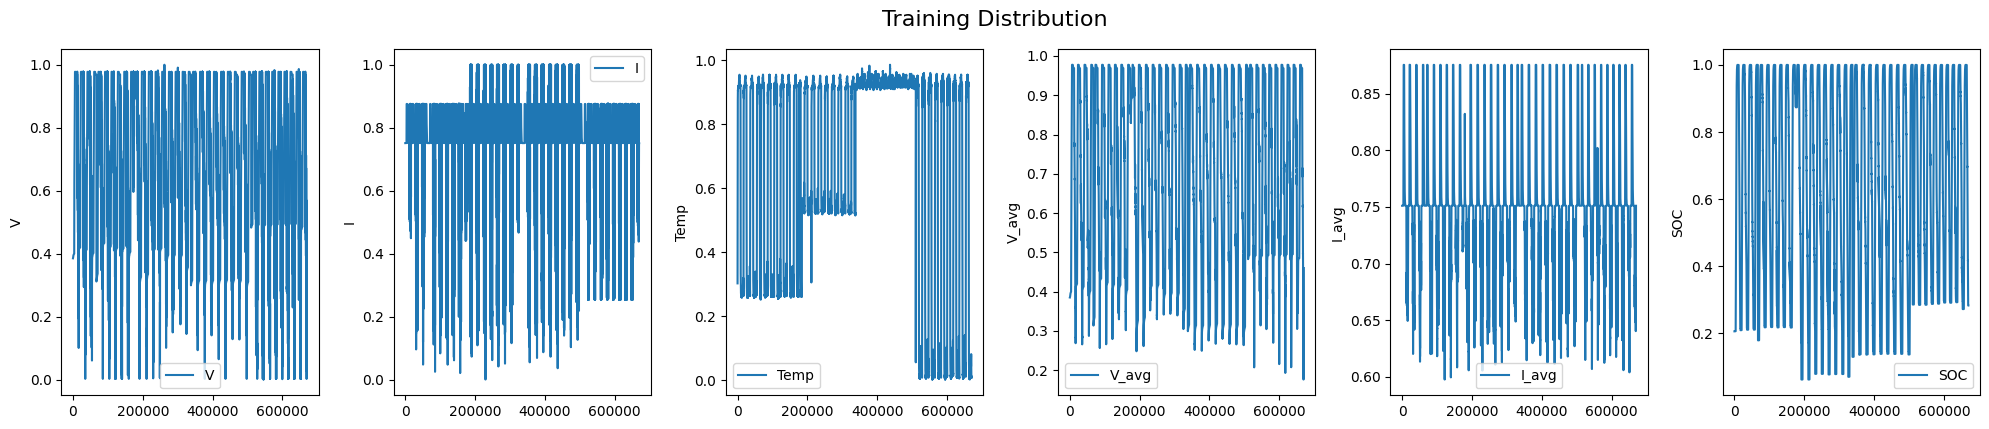

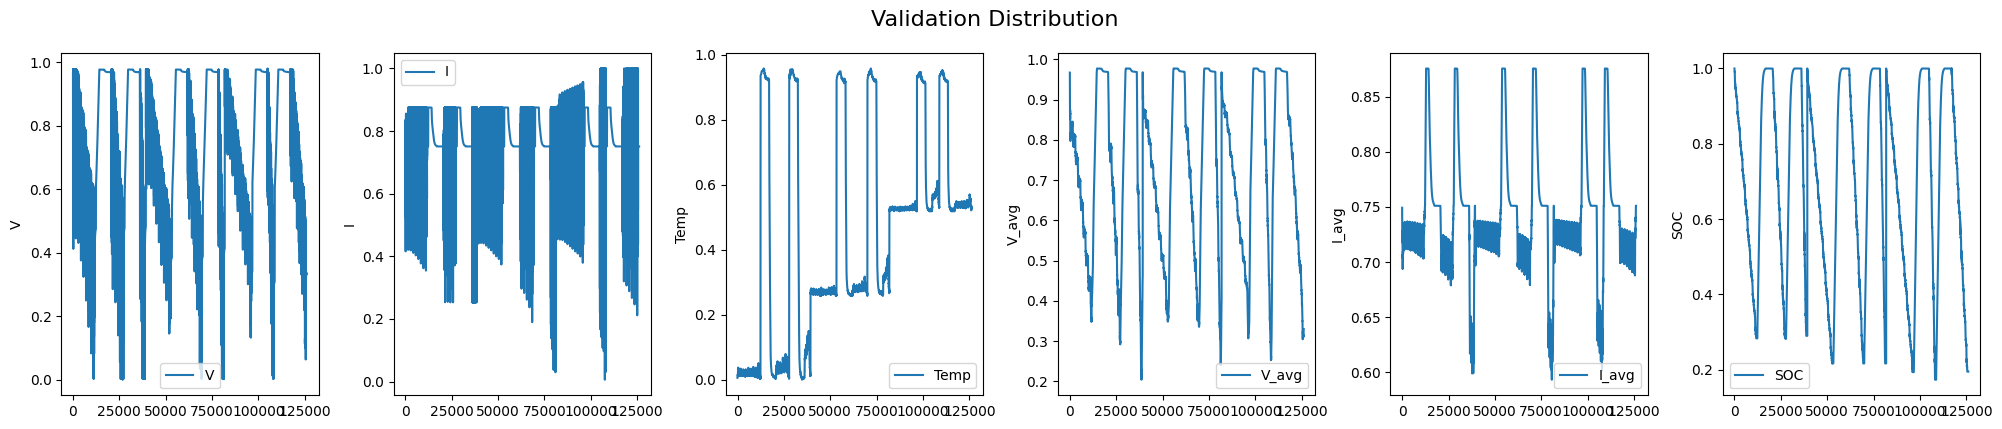

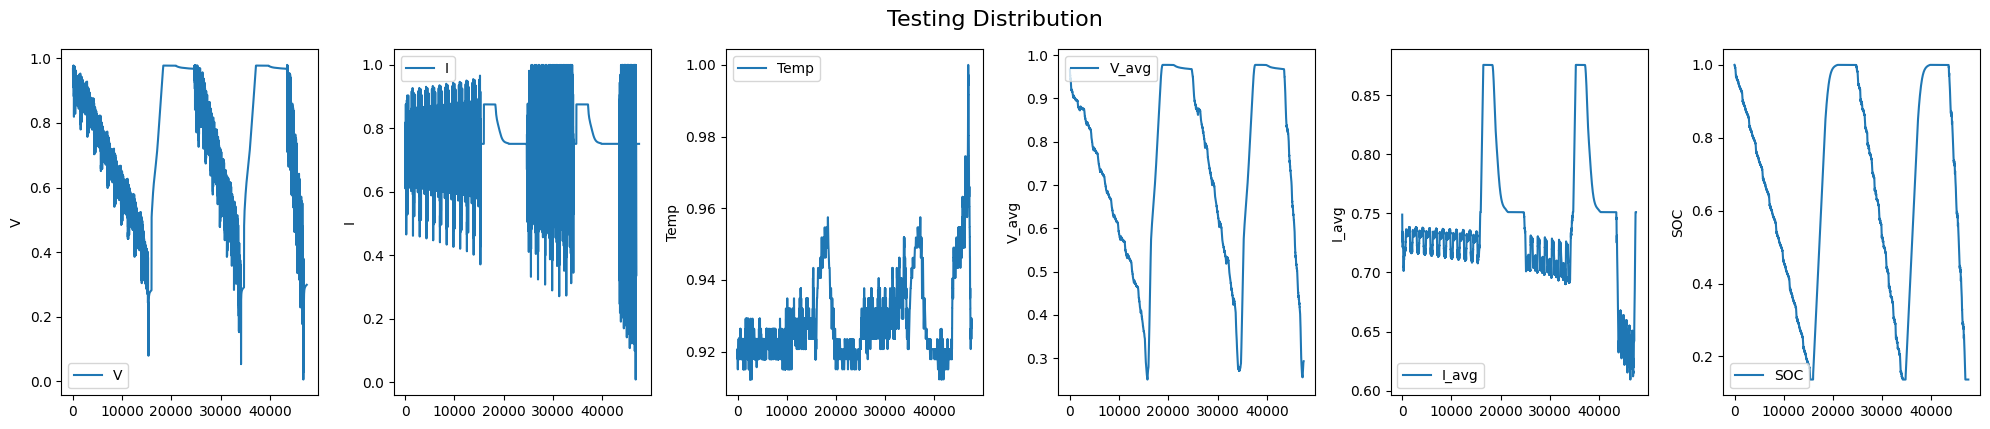

In [19]:
utils.time_series_plot(
    train_data_df=train_data_df, 
    val_data_df=val_data_df, 
    test_data_df=test_data_df
)

<p>
    A heatmap is used to visualize the correlation matrix of the features in the dataset.
</p>

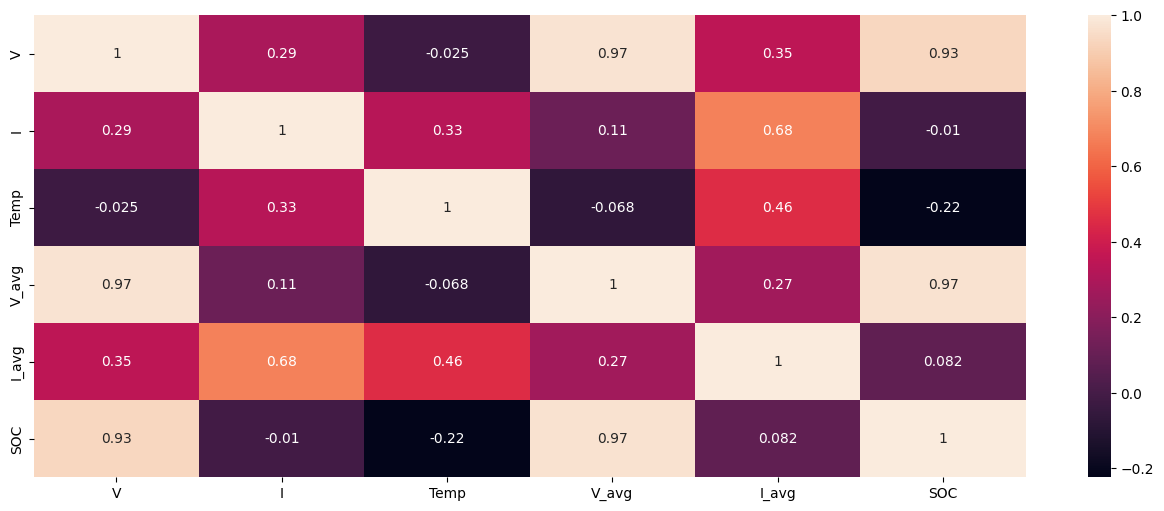

In [20]:
utils.correlation_map(data_df=train_data_df)

In [14]:
from tensorflow import keras

In [8]:
'''
Create an instance of the custom Feedforward Neural Network (FNN).
'''
fnn = custom.FNN(
    input_shape=X_train.shape[1],
    output_shape=y_train.shape[1]
)

'''
Build the FNN model architecture
This method constructs the layers and architecture of the neural network according to the specifications.
'''
fnn.build()

'''
Compile the FNN model
This method prepares the model for training by specifying the optimizer, loss function, and metrics.
'''
fnn.compile()

INFO:root:FNNModel instance created with input shape 5 and output shape 1.
INFO:root:Building the model...
INFO:root:Model built successfully.
INFO:root:Compiling the model...
INFO:root:Model compiled successfully.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,353 (392.00 KB)

 Trainable params: 100,353 (392.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
'''
Create an EarlyStopping callback to monitor the validation loss and stop training early if necessary.
monitor: Monitor the validation loss to determine when to stop training.
patience: Number of epochs with no improvement after which training will be stopped.
'''
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10
)

In [10]:
'''
Train the FNN model using the training data with specified parameters.
x: Input data for training (features)
y: Target data for training (labels/outputs)
epochs: Number of epochs to train the model
batch_size: Number of samples per gradient update
validation_data: A tuple containing, respectively, input and target data for validation
callbacks: List of callbacks to apply during training, including EarlyStopping
verbose: Verbosity mode: 1 = progress bar
'''
history = fnn.get_model().fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=64,
    validation_data=(
        X_val, 
        y_val
    ),
    callbacks = [
        early_stopping
    ],
    verbose=1,
)

Epoch 1/100
10469/10469 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.0076 - val_loss: 0.0038
Epoch 2/100
10469/10469 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 3/100
10469/10469 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 4/100
10469/10469 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 5/100
10469/10469 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 6/100
10469/10469 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 7/100
10469/10469 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 8/100
10469/10469 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 9/100
10469/10469 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 10/100
10469/10469 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 11/100
10469/10469 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0019 - val

In [11]:
fnn_model_name = 'fnn_model.keras'
models_dir = './models'
fnn_model_path = os.path.join(models_dir, fnn_model_name)

'''
Save the trained FNN model to the specified file path.
'''
fnn.get_model().save(filepath=fnn_model_path)

In [12]:
'''
Convert the training history object into a DataFrame for easier analysis, add the epoch numbers to the DataFrame and display the last few rows of the DataFrame to inspect the training history.
'''
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df.tail()

,loss,val_loss,epoch
36,0.001807,0.002600,36
37,0.001807,0.002604,37
38,0.001807,0.002597,38
39,0.001806,0.002607,39
40,0.001806,0.002607,40


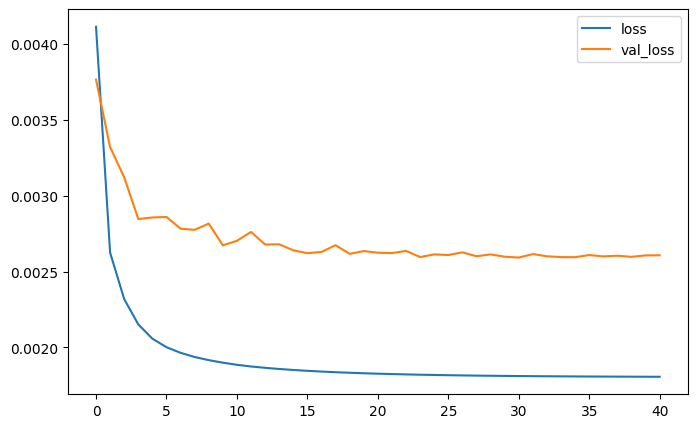

In [13]:
from matplotlib import pyplot as plt

'''
Create a DataFrame from the training history and plot the metrics.
'''
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show() 

In [10]:
fnn_model_name = 'fnn_model.keras'
models_dir = './models'
fnn_model_path = os.path.join(models_dir, fnn_model_name)

'''
Load a previously saved Keras model from the specified file path specifying custom objects (custom.CustomLeakyReLU, custom.CustomClippedReLU) defined in the trained model.
'''
fnn_model = keras.models.load_model(
    filepath=fnn_model_path, 
    custom_objects={
        'CustomLeakyReLU': custom.CustomLeakyReLU,
        'CustomClippedReLU': custom.CustomClippedReLU
    }
)

In [11]:
'''
Use the loaded FNN model to make predictions on the test data and apply the AHIF post-processing function to the predicted values.
'''
y_predicted = fnn_model.predict(X_test)
y_predicted_ahif = ahif.apply(
    data=y_predicted
)

1485/1485 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [12]:
'''
Evaluate the performance of the loaded FNN model on the test data.
'''
result = fnn_model.evaluate(X_test, y_test)

1485/1485 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 8.1109e-04


In [13]:
fnn_metrics = utils.get_metrics(y_test, y_predicted_ahif)
metrics.append(fnn_metrics[0])
fnn_metrics[1]

,Metric,Value
0,max_error,0.182498
1,mean_absolute_error,0.020437
2,mean_absolute_percentage_error,0.055249
3,mean_squared_error,0.000937
4,root_mean_squared_error,0.030604
5,root_mean_squared_log_error,0.021940


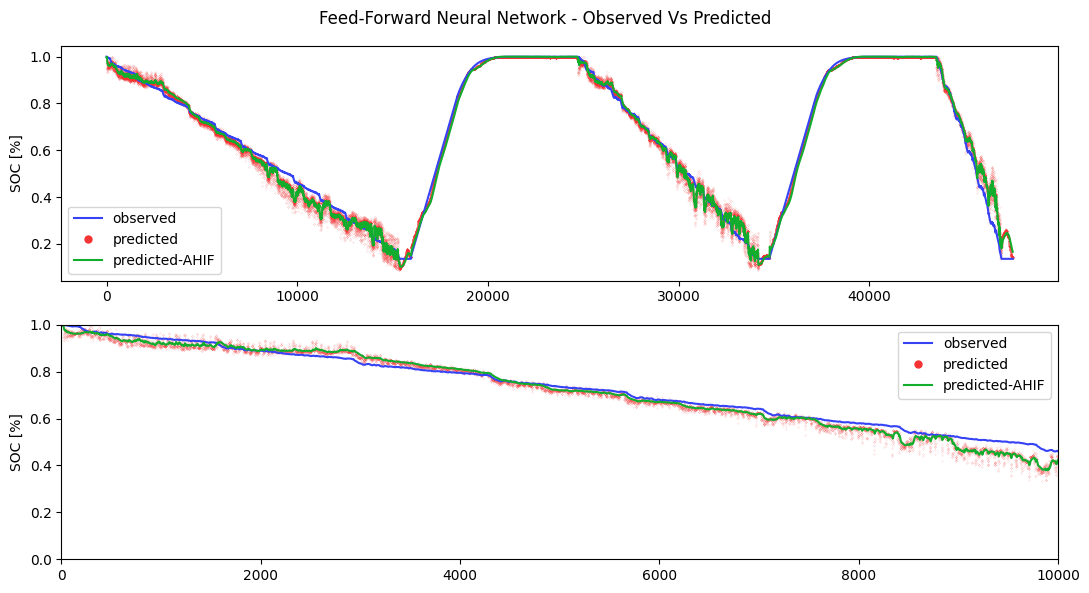

In [14]:
utils.results_plot(
    x=np.arange(0, len(y_test), 1), 
    y_observed=y_test, 
    y_predicted=y_predicted, 
    y_predicted_ahif=y_predicted_ahif,
    xlim=[0,10000],
    ylim=[0,1],
    xlabel='', 
    ylabel='SOC [%]', 
    title='Feed-Forward Neural Network - Observed Vs Predicted'
)

In [15]:
import pickle

In [21]:
from sklearn import linear_model
'''
Initialize a Linear Regression model and fit the Linear Regression model to the training data.
'''
lregression_model = linear_model.LinearRegression()
lregression_model.fit(
    X=X_train,
    y=y_train
)

LinearRegression()

In [22]:
lregression_model_name = 'lregression_model.sav'
models_dir = './models'
lregression_model_path = os.path.join(models_dir, lregression_model_name)

'''
Save the trained Linear Regression model to a file.
'''
pickle.dump(lregression_model, open(lregression_model_path, 'wb'))

In [16]:
lregression_model_name = 'lregression_model.sav'
models_dir = './models'
lregression_model_path = os.path.join(models_dir, lregression_model_name)

'''
Load the trained Linear Regression model from a file.
'''
lregression_model = pickle.load(open(lregression_model_path, 'rb'))

In [17]:
'''
Use the loaded Linear Regression model to make predictions on the test data and apply the AHIF post-processing function to the predicted values.
'''
y_predicted = lregression_model.predict(X_test)
y_predicted_ahif = ahif.apply(
    data=y_predicted
)

In [18]:
'''
Evaluate the performance of the trained Linear Regression model on the test data and print the accuracy of the model as a percentage.
'''
result = lregression_model.score(X_test, y_test)
print("Accuracy: %.2f%%" % (result*100.0))

Accuracy: 86.04%


In [19]:
lregression_metrics = utils.get_metrics(y_test, y_predicted_ahif)
metrics.append(lregression_metrics[0])
lregression_metrics[1]

,Metric,Value
0,max_error,0.253888
1,mean_absolute_error,0.087461
2,mean_absolute_percentage_error,0.192346
3,mean_squared_error,0.011819
4,root_mean_squared_error,0.108715
5,root_mean_squared_log_error,0.073253


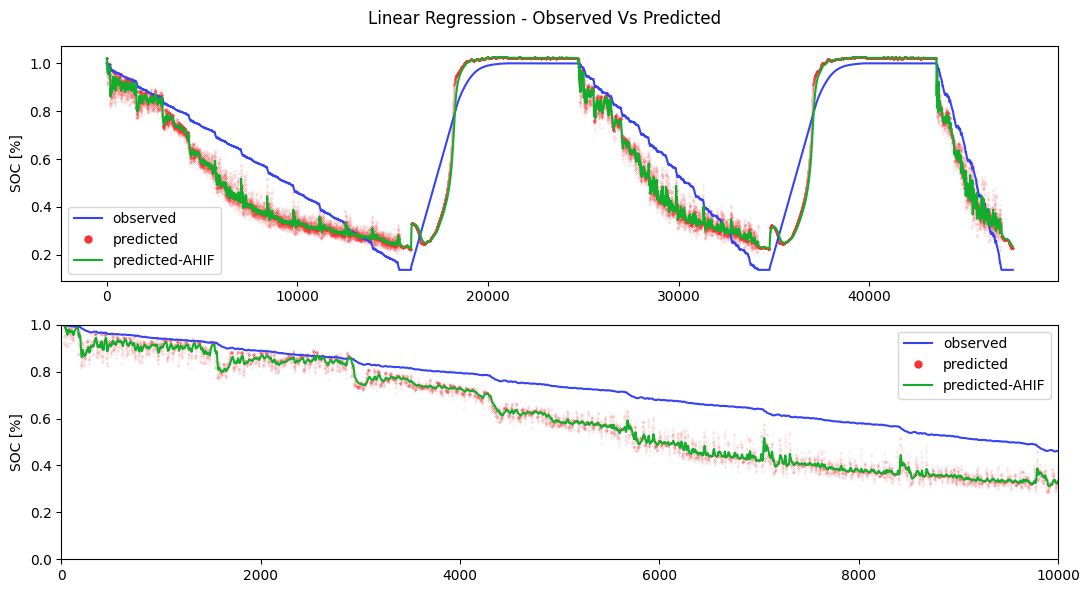

In [20]:
utils.results_plot(
    x=np.arange(0, len(y_test), 1), 
    y_observed=y_test, 
    y_predicted=y_predicted,
    y_predicted_ahif=y_predicted_ahif,
    xlim=[0,10000],
    ylim=[0,1],
    xlabel='', 
    ylabel='SOC [%]', 
    title='Linear Regression - Observed Vs Predicted'
)

In [28]:
from sklearn import tree
'''
Initialize a Decision Tree Regression model and fit the Decision Tree Regression model to the training data.
'''
decisiontree_model = tree.DecisionTreeRegressor()
decisiontree_model.fit(
    X=X_train, 
    y=y_train
)

DecisionTreeRegressor()

In [29]:
decisiontree_model_name = 'decisiontree_model.sav'
models_dir = './models'
decisiontree_model_path = os.path.join(models_dir, decisiontree_model_name)

'''
Save the trained Decision Tree Regression model to a file.
'''
pickle.dump(decisiontree_model, open(decisiontree_model_path, 'wb'))

In [21]:
decisiontree_model_name = 'decisiontree_model.sav'
models_dir = './models'
decisiontree_model_path = os.path.join(models_dir, decisiontree_model_name)

'''
Load the trained Decision Tree Regression model from a file.
'''
decisiontree_model = pickle.load(open(decisiontree_model_path, 'rb'))

In [22]:
'''
Use the loaded Decision Tree Regression model to make predictions on the test data and apply the AHIF post-processing function to the predicted values.
'''
y_predicted = decisiontree_model.predict(X_test)
y_predicted_ahif = ahif.apply(
    data=y_predicted
)

In [23]:
'''
Evaluate the performance of the trained Decision Tree Regression model on the test data and print the accuracy of the model as a percentage.
'''
result = decisiontree_model.score(X_test, y_test)
print("Accuracy: %.2f%%" % (result*100.0))

Accuracy: 97.95%


In [24]:
decisiontree_metrics = utils.get_metrics(y_test, y_predicted_ahif)
metrics.append(decisiontree_metrics[0])
decisiontree_metrics[1]

,Metric,Value
0,max_error,0.238272
1,mean_absolute_error,0.019566
2,mean_absolute_percentage_error,0.054808
3,mean_squared_error,0.001008
4,root_mean_squared_error,0.031747
5,root_mean_squared_log_error,0.023386


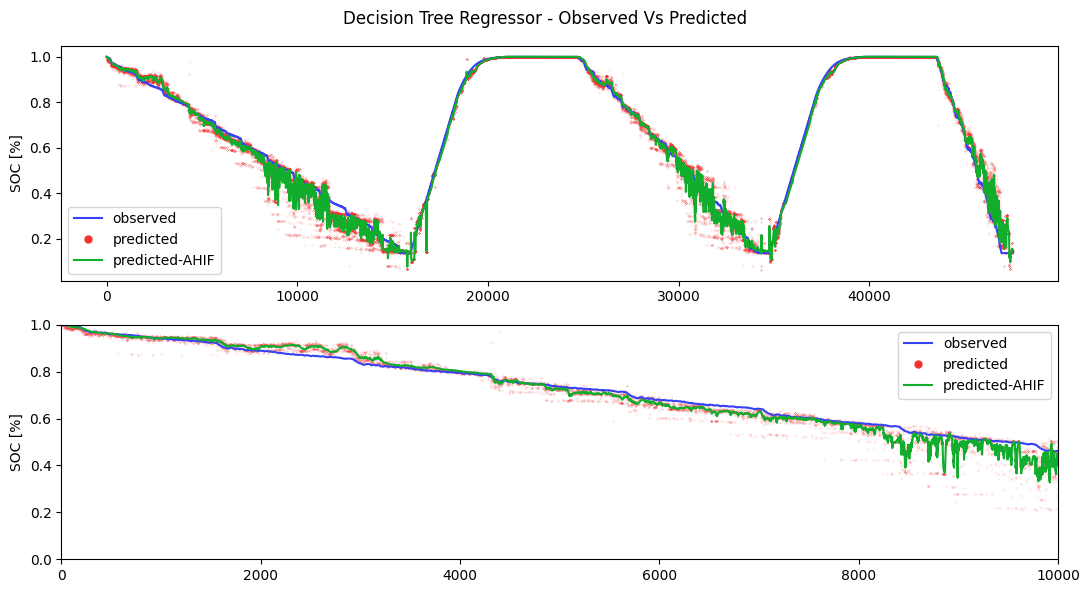

In [25]:
utils.results_plot(
    x=np.arange(0, len(y_test), 1), 
    y_observed=y_test, 
    y_predicted=y_predicted,
    y_predicted_ahif=y_predicted_ahif,
    xlim=[0,10000],
    ylim=[0,1],
    xlabel='', 
    ylabel='SOC [%]', 
    title='Decision Tree Regressor - Observed Vs Predicted'
)

In [35]:
from sklearn import neighbors
'''
Initialize a K-Nearest Neighbors Regression model and fit the K-Nearest Neighbors Regression model to the training data.
'''
nnregression_model = neighbors.KNeighborsRegressor(n_neighbors=5)
nnregression_model.fit(
    X=X_train, 
    y=y_train
)

KNeighborsRegressor()

In [36]:
nnregression_model_name = 'nnregression_model.sav'
models_dir = './models'
nnregression_model_path = os.path.join(models_dir, nnregression_model_name)

'''
Save the trained K-Nearest Neighbors Regression model to a file.
'''
pickle.dump(nnregression_model, open(nnregression_model_path, 'wb'))

In [26]:
nnregression_model_name = 'nnregression_model.sav'
models_dir = './models'
nnregression_model_path = os.path.join(models_dir, nnregression_model_name)

'''
Load the trained K-Nearest Neighbors Regression model from a file.
'''
nnregression_model = pickle.load(open(nnregression_model_path, 'rb'))

In [27]:
'''
Use the loaded K-Nearest Neighbors Regression model to make predictions on the test data and apply the AHIF post-processing function to the predicted values.
'''
y_predicted = nnregression_model.predict(X_test)
y_predicted_ahif = ahif.apply(
    data=y_predicted
)

In [28]:
'''
Evaluate the performance of the trained K-Nearest Neighbors Regression model on the test data and print the accuracy of the model as a percentage.
'''
result = nnregression_model.score(X_test, y_test)
print("Accuracy: %.2f%%" % (result*100.0))

Accuracy: 98.78%


In [29]:
nnregression_metrics = utils.get_metrics(y_test, y_predicted_ahif)
metrics.append(nnregression_metrics[0])
nnregression_metrics[1]

,Metric,Value
0,max_error,0.174067
1,mean_absolute_error,0.017985
2,mean_absolute_percentage_error,0.049050
3,mean_squared_error,0.000781
4,root_mean_squared_error,0.027946
5,root_mean_squared_log_error,0.020337


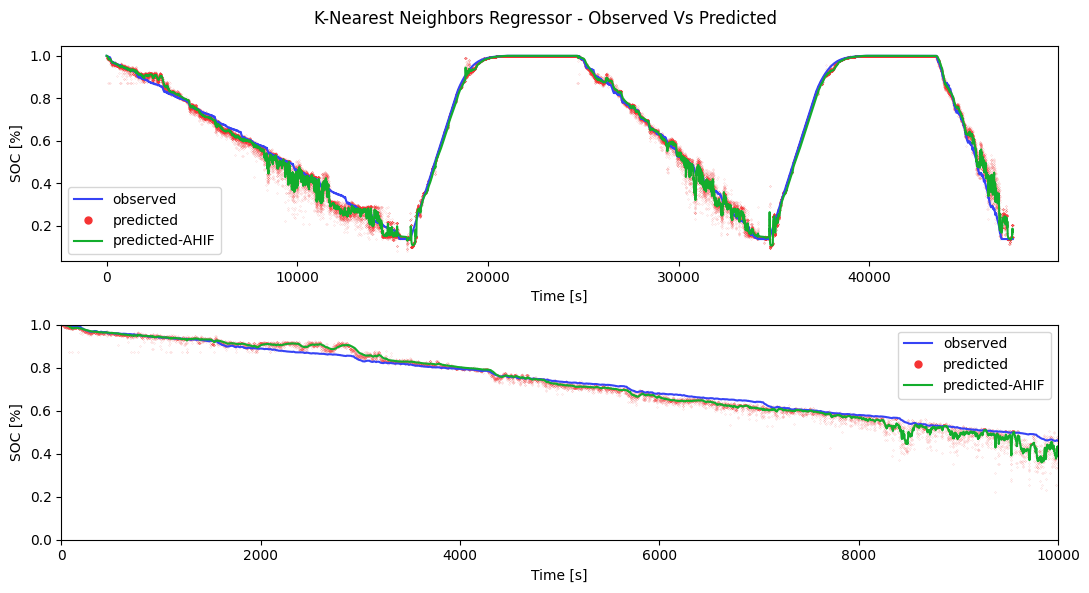

In [30]:
utils.results_plot(
    x=np.arange(0, len(y_test), 1), 
    y_observed=y_test, 
    y_predicted=y_predicted,
    y_predicted_ahif=y_predicted_ahif,
    xlim=[0,10000],
    ylim=[0,1],
    xlabel='Time [s]', 
    ylabel='SOC [%]', 
    title='K-Nearest Neighbors Regressor - Observed Vs Predicted'
)

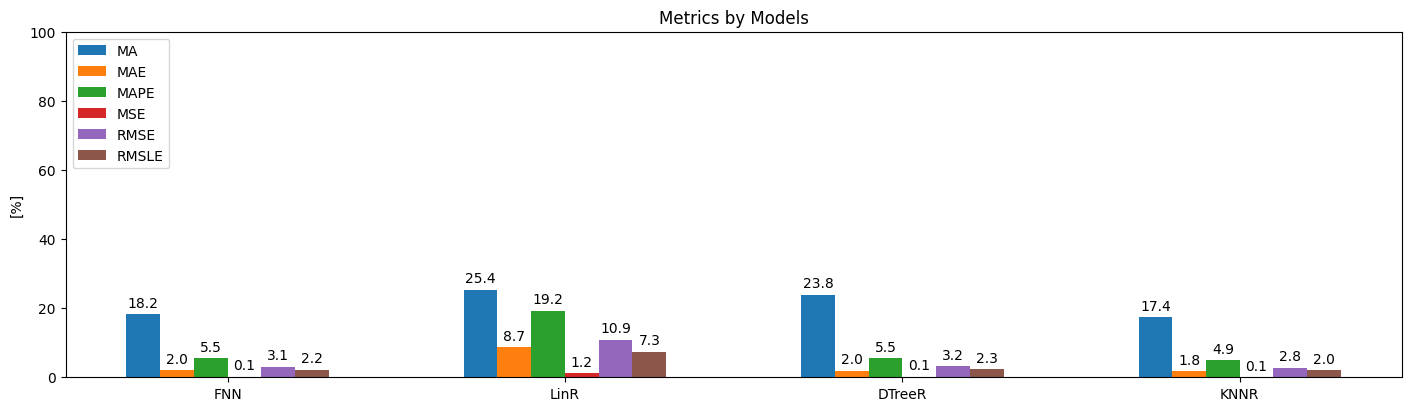

In [31]:
'''
Metrics comparison among FNN, Linear Regression, Decision Tree Regression and K-Nearest Neighbors Regression.
'''
utils.metrics_plot(
    models_names=['FNN', 'LinR', 'DTreeR', 'KNNR'],
    metrics_names=['MA', 'MAE', 'MAPE', 'MSE', 'RMSE', 'RMSLE'],
    metrics_values=metrics
)

In [11]:
import shap

In [12]:
'''
SHAP library for model interpretability (Explainable Artificial Intelligence).
shap.sample: Sample a subset of the test data for faster SHAP value computation
shap.KernelExplainer: Initialize the SHAP KernelExplainer with the model's prediction function and sampled data
explainer.shap_values: Compute SHAP values for the sampled test data
np.squeeze: Convert the SHAP values to a numpy array, removing any singleton dimensions
'''

X_test_sampled = shap.sample(X_test, 100)
explainer = shap.KernelExplainer(fnn_model.predict, X_test_sampled)
shap_values = explainer.shap_values(X_test_sampled)
shap_values = np.squeeze(shap_values)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
INFO:shap:num_full_subsets = 2
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
INFO:shap:phi = array([ 0.08815733,  0.04029656,  0.0026937 , -0.08347745,  0.09228188])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
INFO:shap:num_full_subsets = 2
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
INFO:shap:phi = array([-0.02333852,  0.06441332,  0.0018691 , -0.08396406,  0.05336757])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
INFO:shap:num_full_subsets = 2
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
INFO:shap:phi = array([-0.15348303, -0.09459287, -0.00219353, -0.09266132, -0.14393826])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
INFO:shap:num_full_subsets = 2
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
INFO:shap:phi = array([-0.13181864, -0.01674975,  0.00069491, -0.05713653, -0.08282998])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
INFO:shap:num_full_subsets = 2
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
INFO:shap:phi = array([ 0.09510508, -0.01122086,  0.00394166, -0.03591639, -0.06810531])
1/1 ━━━━━━━

In [ ]:
'''
Initialize JavaScript visualization for SHAP.
'''
shap.initjs()

In [47]:
features = list(test_data_df.columns)
target = [features.pop(-1)]
print(f'features = {features}')
print(f'target = {target}')

features = ['V', 'I', 'Temp', 'V_avg', 'I_avg']
target = ['SOC']


In [44]:
shap_values[0]

array([ 0.08815733,  0.04029656,  0.0026937 , -0.08347745,  0.09228188])

In the waterfall above, the x-axis has the values of the target (dependent) variable which is the SOC. x is the chosen observation, f(x) is the predicted value of the model, given input x and E[f(x)] is the expected value of the target variable, or in other words, the mean of all predictions (mean(model.predict(X))).\
The SHAP value for each feature in this observation is given by the length of the bar. Above, I_avg has a SHAP value of +0.09, V_avg has a SHAP of -0.08 and so on. The sum of all SHAP values will be equal to E[f(x)] — f(x).\
The absolute SHAP value shows us how much a single feature affected the prediction, so I_avg contributed the most, V the second one, V_avg the third, I the fourth and Temp was the feature with the lowest contribution to the prediction.

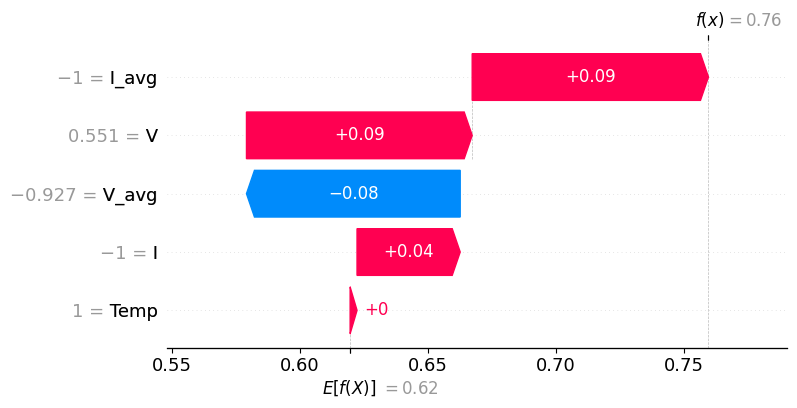

In [48]:
'''
Create a SHAP Explanation object for the selected sample, generate and display a SHAP waterfall plot for the selected sample x.
'''
x = 0
shap_explanation = shap.Explanation(
    values=shap_values[x],
    base_values=explainer.expected_value,
    data=X_test_sampled[x],
    feature_names=features
)
shap.plots.waterfall(shap_explanation)

Note that these SHAP values are valid for this observation only. With other data points the SHAP values will change. In order to understand the importance or contribution of the features for the whole dataset, another plot can be used, the bee swarm plot or use summary_plot.\
For example, high values of the I_avg variable have a high negative contribution on the prediction, while low values have a high positive contribution. The feature Temp has almost no contribution to the prediction, whether its values are high or low.
All variables are shown in the order of global feature importance, the first one being the most important and the last being the least important one.

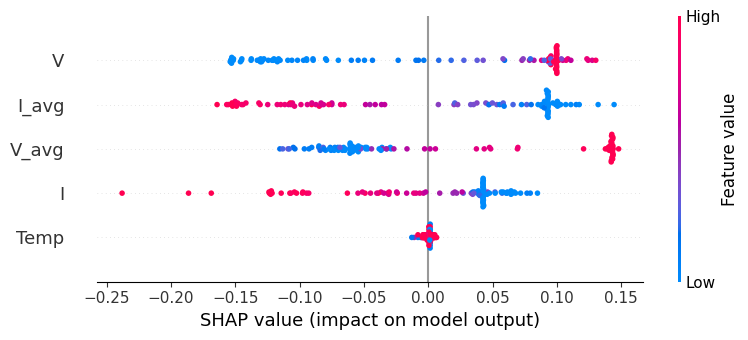

In [52]:
'''
Generate and display a SHAP summary plot for the sampled test data.
'''
shap.summary_plot(shap_values, X_test_sampled, feature_names=features)